# Scripts for Replication
Using this script you can replicate the results of the paper "On the Impact of Hitting System Resource Limitations on Test Flakiness".

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display

Loading the dataset (make sure the path is correct):

In [2]:
test_cases = json.load(open('data/aggregated-stats.json'))

We define a `RESOURCE` and `THRESHOLD` that we want to analyze.
The `RESOURCE` can be one of the following:
- userLoad (CPU load by user processes)
- systemLoad (CPU load by system processes)
- totalLoad (total CPU load)
- activeMemory (memory usage)
- availableMemory
- networkRead
- networkWrite
- diskRead
- diskWrite

The `THRESHOLD` defines what test cases or runs we consider as having reached the resource's limitations. In the following, we will always check if the defined `RESOURCE` is greater or equal the defined `THRESHOLD`.

In [3]:
RESOURCE = "totalLoad"
THRESHOLD = 100
USE_LATEX = True # Set to False if you don't have LaTeX installed

# Data Preprocessing

We iterate over all test cases and their executions. For each run, we extract the resource's values and compare them to the threshold.

We add every run to a dataframe that we will use for the analysis.

In [4]:
iterations = []
for test_case in test_cases:
    for key, iteration in (test_case["passed_iterations"] | test_case["failed_iterations"]).items():
         # Our dataset contains two objects for each test case: the failed and passed iterations.
         # We determine if the run passed or failed by checking if its key is in the passed_iterations dictionary.
        verdict = "PASSED" if key in test_case["passed_iterations"] else "FAILED"
        measurements = pd.Series([measurement[RESOURCE] for measurement in iteration]) # Extract the measurements for the current run and for the given resource

        iterations.append([test_case["testCase"],
                           verdict,
                           test_case['entropy'] > 0,
                           measurements.min(),
                           measurements.median(),
                           measurements.mean(),
                           measurements.max(),
                           measurements.size,
                           (measurements >= THRESHOLD).sum() / measurements.size # Fraction of measurements that reached the resource limit threshold
                           ])

# Create a dataframe from the collected data
df = pd.DataFrame(iterations, columns=["Test", "Verdict", "Flaky", "Min", "Median", "Mean", "Max", "Size", "Fraction of reaching resource limit"])
df.head()

,Test,Verdict,Flaky,Min,Median,Mean,Max,Size,Fraction of reaching resource limit
0,'-[KometUITests.KometUITests testAddingComment...,PASSED,False,84.615385,100.000000,98.146725,100.0,106,0.679245
1,'-[KometUITests.KometUITests testAddingComment...,PASSED,False,36.666667,97.368421,85.696577,100.0,94,0.382979
2,'-[KometUITests.KometUITests testAddingComment...,PASSED,False,25.423729,89.873418,79.689769,100.0,95,0.231579
3,'-[KometUITests.KometUITests testAddingComment...,PASSED,False,27.118644,93.548387,80.492684,100.0,97,0.195876
4,'-[KometUITests.KometUITests testAddingComment...,PASSED,False,15.254237,93.243243,79.938149,100.0,94,0.308511


# Descriptive Data

We can retrieve some basic information about the dataset:

In [5]:
distinct_test_cases = df.groupby(["Test"])["Flaky"].unique()
print("Number of test cases: ", distinct_test_cases.size)
print("Number of flaky test cases: ", sum(distinct_test_cases))
print("Number of non-flaky test cases: ", sum(~distinct_test_cases))
print("Number of total test runs: ", df.shape[0])

Number of test cases:  232
Number of flaky test cases:  [23]
Number of non-flaky test cases:  [209]
Number of total test runs:  6841


# Results

In [6]:
# Define functions to analyze and plot the results...
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Palatino",
    'font.size': 14,
})

def plot_data(series, labels, title):
    fig, ax = plt.subplots()
    plt.rcParams['text.usetex'] = USE_LATEX

    for s, label in zip(series, labels):
        cdf = s.sort_values().reset_index(drop=True).reset_index()
        ax.plot(cdf['index']/len(cdf), cdf["Fraction of reaching resource limit"], label=f"{label}")

    ax.set_xlabel('Share of Test Executions')
    ax.set_ylabel('Relative Time Spent in CPU Limit')
    ax.legend()
    fig.tight_layout()

    plt.savefig(f"plot_{title}.pdf")
    
def perform_mwutest(data_group1, data_group2):
    u_stat, p_val = stats.mannwhitneyu(data_group1, data_group2)
    print(f"u-statistic: {u_stat}, p-value: {p_val}")

## RQ 1 (Executions of Flaky versus Non-flaky Tests)
### Visual and Statistical Analysis of the Data

> To what extent do executions of flaky tests reach the CPU limit compared to executions of non-flaky tests?

We retrieve the fraction of runs that reach the CPU limit for runs of flaky and non-flaky tests:

In [7]:
flaky_runs_at_limit = df[df["Flaky"]]["Fraction of reaching resource limit"]
non_flaky_runs_at_limit = df[df["Flaky"] == False]["Fraction of reaching resource limit"]
display(flaky_runs_at_limit.rename("Fraction of flaky test cases reaching resource limit").describe())
display(non_flaky_runs_at_limit.rename("Fraction of non-flaky test cases reaching resource limit").describe())

perform_mwutest(flaky_runs_at_limit, non_flaky_runs_at_limit)

count    690.000000
mean       0.293310
std        0.359519
min        0.000000
25%        0.000000
50%        0.078990
75%        0.551632
max        1.000000
Name: Fraction of flaky test cases reaching resource limit, dtype: float64

count    6151.000000
mean        0.094462
std         0.209877
min         0.000000
25%         0.000000
50%         0.000000
75%         0.063830
max         1.000000
Name: Fraction of non-flaky test cases reaching resource limit, dtype: float64

u-statistic: 2931497.5, p-value: 5.20228115425612e-77


We also create a plot that intuitively shows the difference between the two groups:

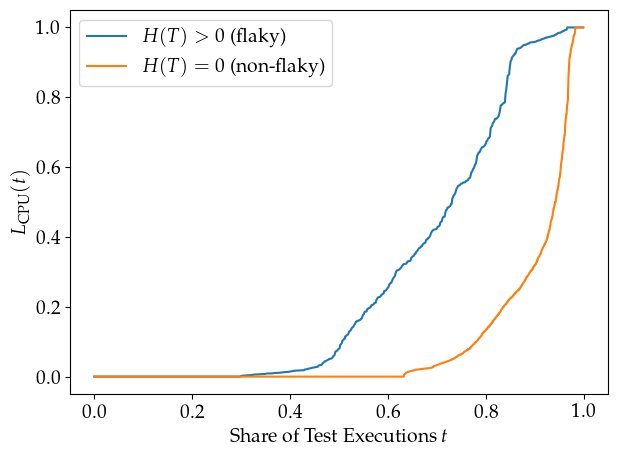

In [8]:
plot_data(series=[flaky_runs_at_limit, non_flaky_runs_at_limit],
        labels=[f"$H_r(T) > 0$ (flaky)", f"$H_r(T) = 0$ (non-flaky)"],
        title="flaky-non-flaky")

## RQ 2 (Passes versus Failures of Flaky Tests)
### Visual and statistical analysis of the data

> To what extent do failing executions of flaky tests reach the CPU limit compared to passing executions?

Fot this reseearch question, we only consider flaky tests:


In [9]:
df_flaky = df[df["Flaky"]]

This time we retrieve the fraction of runs that reach the CPU limit for runs that pass and runs that fail:

In [10]:
passing_runs = df_flaky[df_flaky["Verdict"] == "PASSED"]["Fraction of reaching resource limit"]
failing_runs = df_flaky[df_flaky["Verdict"] == "FAILED"]["Fraction of reaching resource limit"]
display(passing_runs.rename("Fraction of flaky test cases reaching resource limit (passed)").describe())
display(failing_runs.rename("Fraction of flaky test cases reaching resource limit (failed)").describe())

perform_mwutest(passing_runs, failing_runs)

count    362.000000
mean       0.336328
std        0.337291
min        0.000000
25%        0.017722
50%        0.237468
75%        0.561419
max        1.000000
Name: Fraction of flaky test cases reaching resource limit (passed), dtype: float64

count    328.000000
mean       0.245833
std        0.377410
min        0.000000
25%        0.000000
50%        0.007399
75%        0.470458
max        1.000000
Name: Fraction of flaky test cases reaching resource limit (failed), dtype: float64

u-statistic: 74865.5, p-value: 1.8734785537855945e-09


We can again create a plot that intuitively shows the difference between the two groups:

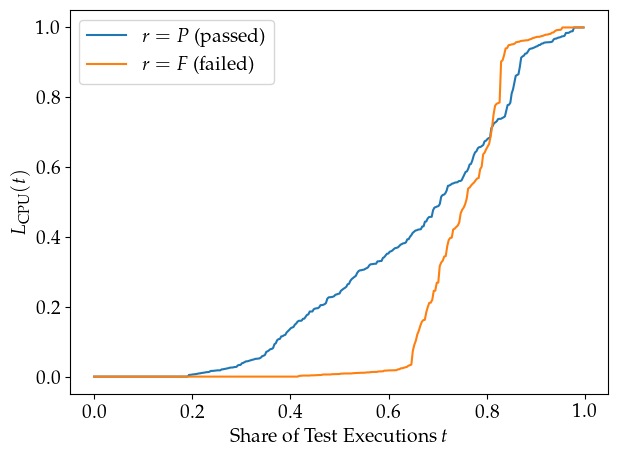

In [11]:
plot_data(series=[passing_runs, failing_runs],
          labels=[f"$r=P$ (passed)", f"$r=F$ (failed)"],
          title="passed-failed")